In [1]:
import os
import sys
from collections import OrderedDict

In [2]:
sys.path.append("../..")

In [3]:
import spatialpy
spatialpy.__file__

'/Users/bryanrumsey/Documents/SpatialPy/examples/cylinderDemo/../../spatialpy/__init__.py'

In [4]:
import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
class Edge1(spatialpy.Geometry):
    def inside(self, point, on_boundary):
        return abs(point[0] - MAX_X_DIM) < 0.05
class Edge2(spatialpy.Geometry):
    def inside(self, point, on_boundary):
        return abs(point[0] - MIN_X_DIM) < 0.05
class Middle(spatialpy.Geometry):
    def inside(self, point, on_boundary):
        return abs(point[0] - MIN_X_DIM) >= 0.05

In [7]:
class cylinderDemo3D(spatialpy.Model):
    def __init__(self, model_name="cylinder_demo3d"):
        spatialpy.Model.__init__(self, model_name)

        self.timestep_size = 1
        
        # System constants
        D_const = 0.1

        # Define Species
        A = spatialpy.Species(name="A", diffusion_coefficient=D_const, restrict_to=[1,2])
        B = spatialpy.Species(name="B", diffusion_coefficient=D_const, restrict_to=[1,3])
        self.add_species([A, B])

        # Define Domain
        domain = spatialpy.Domain.read_xml_mesh('cylinder.xml')
        domain.set_properties(Middle(), 1)
        domain.set_properties(Edge1(), 2)
        domain.set_properties(Edge2(), 3)
        self.add_domain(domain)

        vol = self.domain.get_vol()
        print("vol",vol)
        type_id = self.domain.type
        left = numpy.sum(vol[type_id == 2])
        right = numpy.sum(vol[type_id == 3])
        print("left "+str(left)+" right "+str(right))
        
        k_react = spatialpy.Parameter(name="k_react", expression=1.0)
        k_creat1 = spatialpy.Parameter(name="k_creat1", 
                                     expression=100/left)
        k_creat2 = spatialpy.Parameter(name="k_creat2", 
                                     expression=100/right)
        self.add_parameter([k_react, k_creat1,k_creat2])


        # Define Reactions
        R1 = spatialpy.Reaction(reactants={}, products={A:1}, 
                                rate=k_creat1, restrict_to=2)
        R2 = spatialpy.Reaction(reactants={}, products={B:1}, 
                              rate=k_creat2, restrict_to=3)
        R3 = spatialpy.Reaction(reactants={A:1, B:1}, products={}, 
                              rate=k_react)
        self.add_reaction([R1, R2, R3])
        
        # Define simulation timespan
        # timestep_size be set to much smaller than 1 for deterministic to work, increases simulation time
        self.timespan(numpy.linspace(0,500,501), timestep_size=1e-3)

In [8]:
model = cylinderDemo3D()

vol [0.01513526 0.07034112 0.02382667 ... 0.01674217 0.02120607 0.01969156]
left 0.5092013833059308 right 0.505804729089437


In [9]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 8 ms, sys: 4.5 ms, total: 12.5 ms
Wall time: 579 ms
/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/spatialpy_build_w9u9p22k


In [10]:
%time result = sol.run()
print(result.result_dir)

CPU times: user 2.18 ms, sys: 5.2 ms, total: 7.38 ms
Wall time: 4min 11s
/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/spatialpy_result_izyybx_h


22562.0
22432.0
0.5092013833059308
0.505804729089437


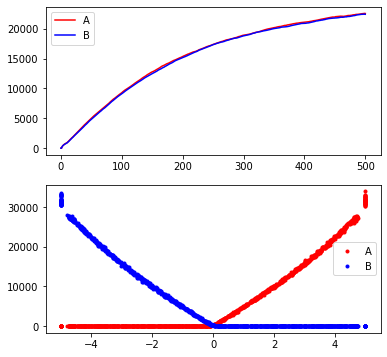

In [11]:
# Plot of the time-average spatial concentration.
x_vals = model.domain.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=False, debug=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=False, debug=False), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.domain.vol
type = model.domain.type
print(numpy.sum(vol[type == 2]))
print(numpy.sum(vol[type == 3]))


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')


In [12]:
def plot_step(t_ndx,key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    plt.scatter(pts[:,0],pts[:,1],c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx))

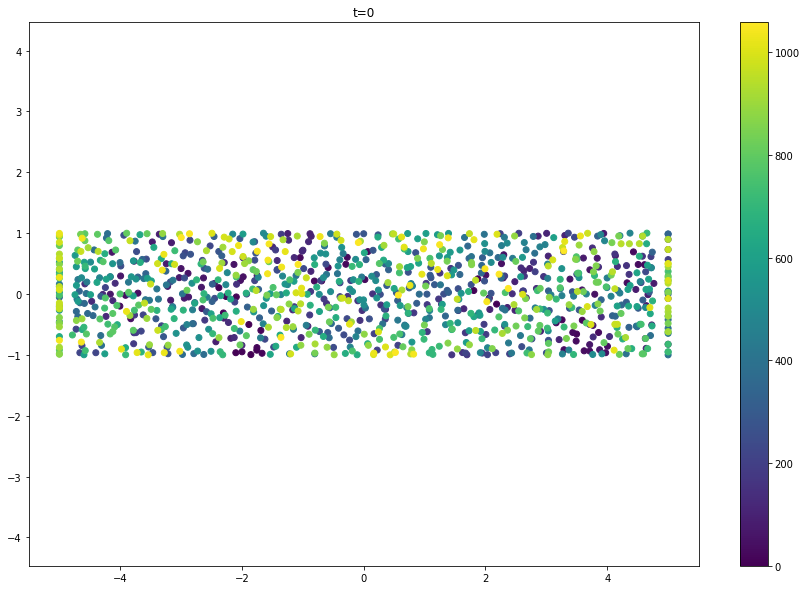

In [13]:
plot_step(0,'id')

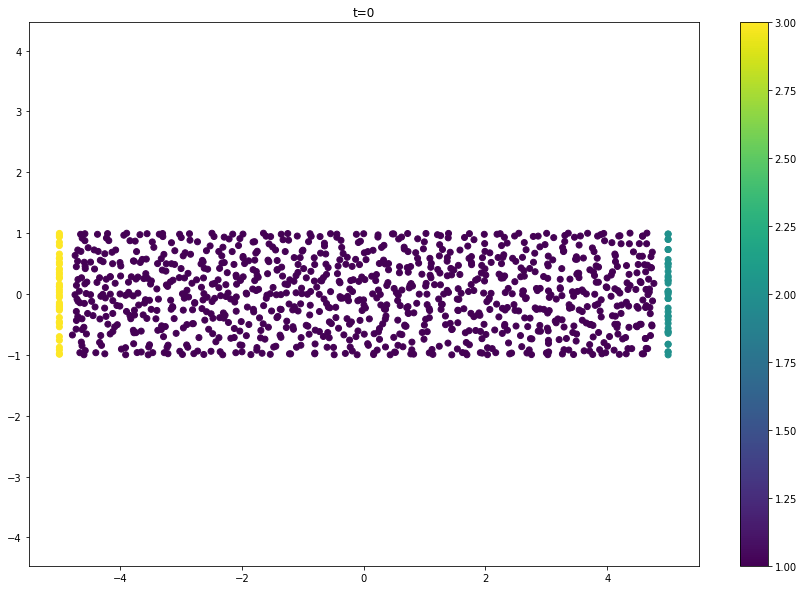

In [14]:
plot_step(0)

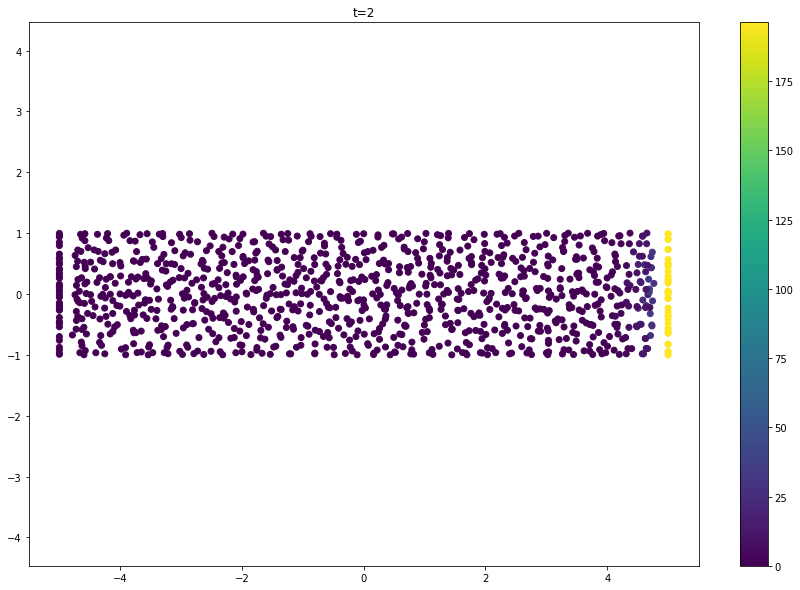

In [15]:
plot_step(2,'C[A]')

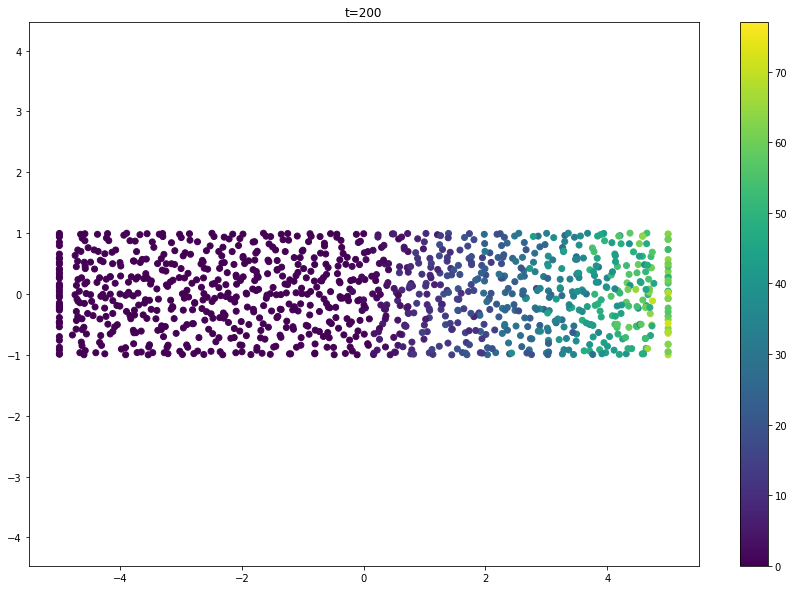

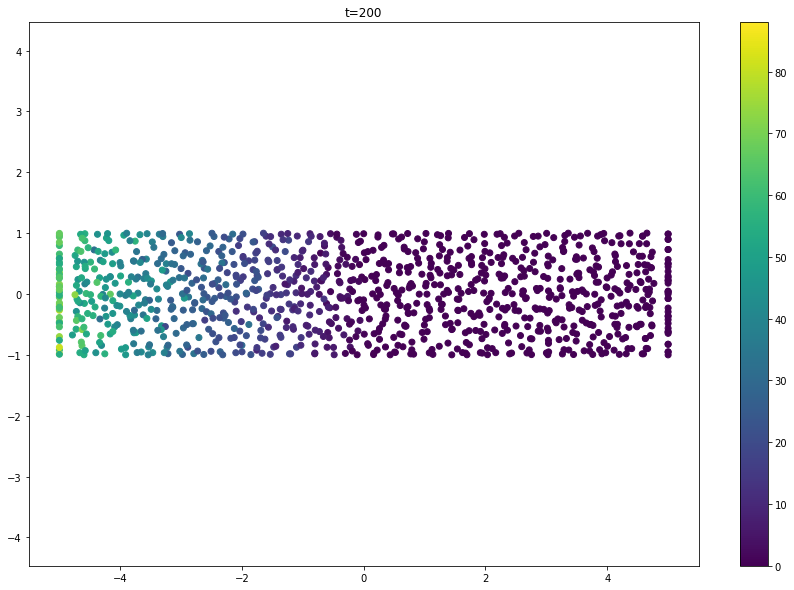

In [16]:
t=200
plot_step(t,'D[A]')
plot_step(t,'D[B]')

In [17]:
# Plot the subdomains
result.plot_property("type", 2)

In [18]:
result.plot_species("A", t_ndx=-1, deterministic=True)

In [19]:
result.plot_species("A", t_ndx=-1, size=10)

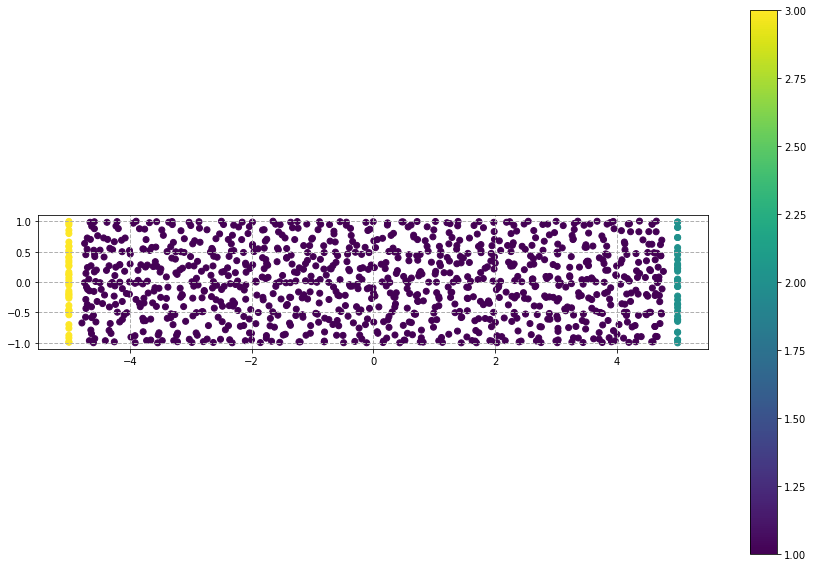

In [20]:
result.plot_property("type", use_matplotlib=True, width=15, height=10)

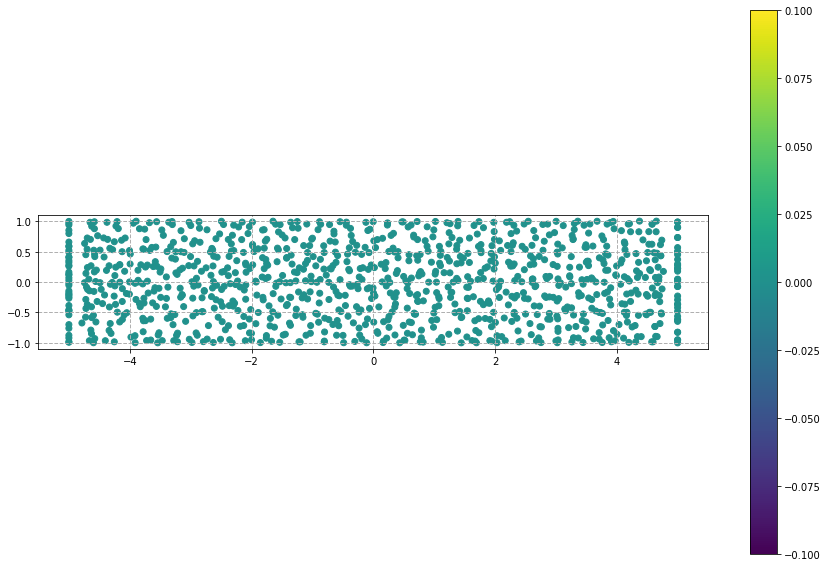

In [21]:
result.plot_species("A", deterministic=True, use_matplotlib=True, width=15, height=10)

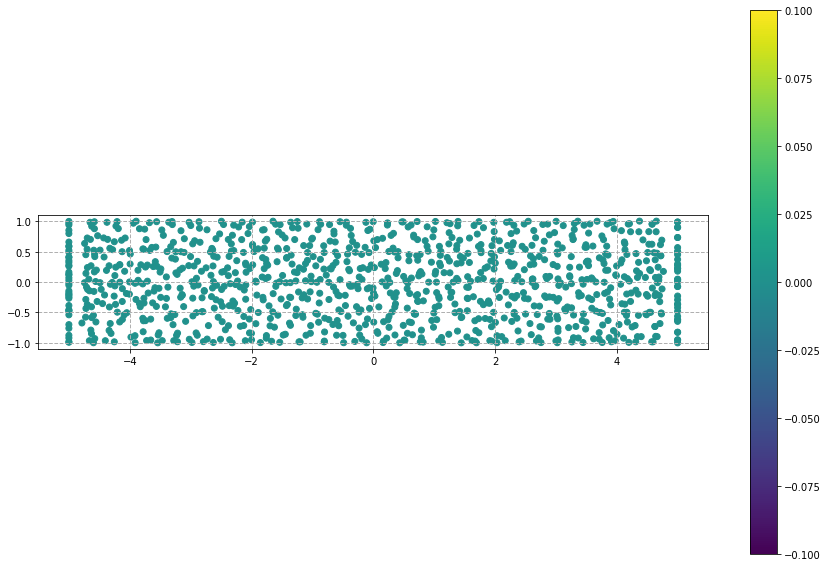

In [22]:
result.plot_species("A", use_matplotlib=True, width=15, height=10)